# KFold cross validation behaviour

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5


def visualize_groups(classes, groups, name, ax):
    # Visualize dataset groups
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, np.max(group)],
    )
    # ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [13]:
import pandas as pd

DATA_DIR = "../project_dataset"
TRAIN_DIR = f"{DATA_DIR}/partial_dataset_train"

X = pd.read_csv(f"{TRAIN_DIR}/features.csv", index_col=0)[:30000]
y = pd.read_csv(f"{TRAIN_DIR}/labels.csv", index_col=0)[:30000]
cl_df = pd.read_csv(f"{TRAIN_DIR}/complete_labels.csv", index_col=0)[:30000]

if "group_id" in cl_df:
    cl_df.drop("group_id", axis=1)

cl_df["group_id"] = cl_df.astype(bool).groupby(cl_df.columns.tolist(), sort=False).ngroup() + 1
min_ = cl_df["group_id"].min()
max_ = cl_df["group_id"].max()

def f(r):
    if r["label"] == False:
        r["group_id"] = np.random.randint(min_, max_, size=1)[0]
    return r["group_id"]

group_ids = cl_df[["label", "group_id"]].apply(f, axis=1)

X = X.values
y = y.values.squeeze()
groups = group_ids.to_numpy()

## Cross Validation

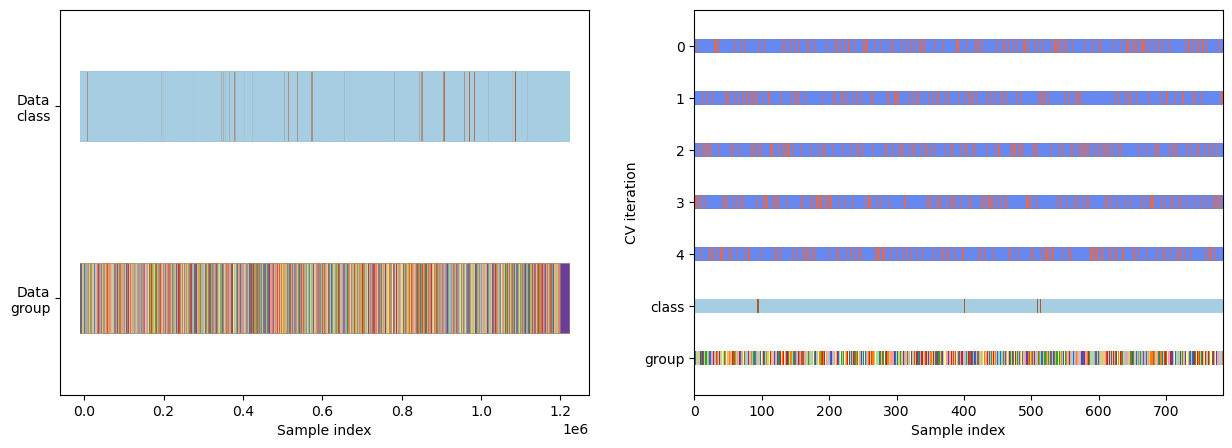

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
cv = StratifiedGroupKFold(n_splits)
visualize_groups(y, groups, "no groups", ax[0])
plot_cv_indices(cv, X, y, groups, ax[1], n_splits)
# plt.tight_layout()
# plt.savefig("../images/cv_kfold.png")
plt.show()

In [19]:
z = np.array([0, 1, 1, 1, 2, 3, 0 , 0])
# np.random.shuffle()
# np.where(z == 0)
ppp = np.where(y == False)[0]
np.random.shuffle(ppp)


array([    0,     1,     2, ..., 29997, 29998, 29999], dtype=int64)

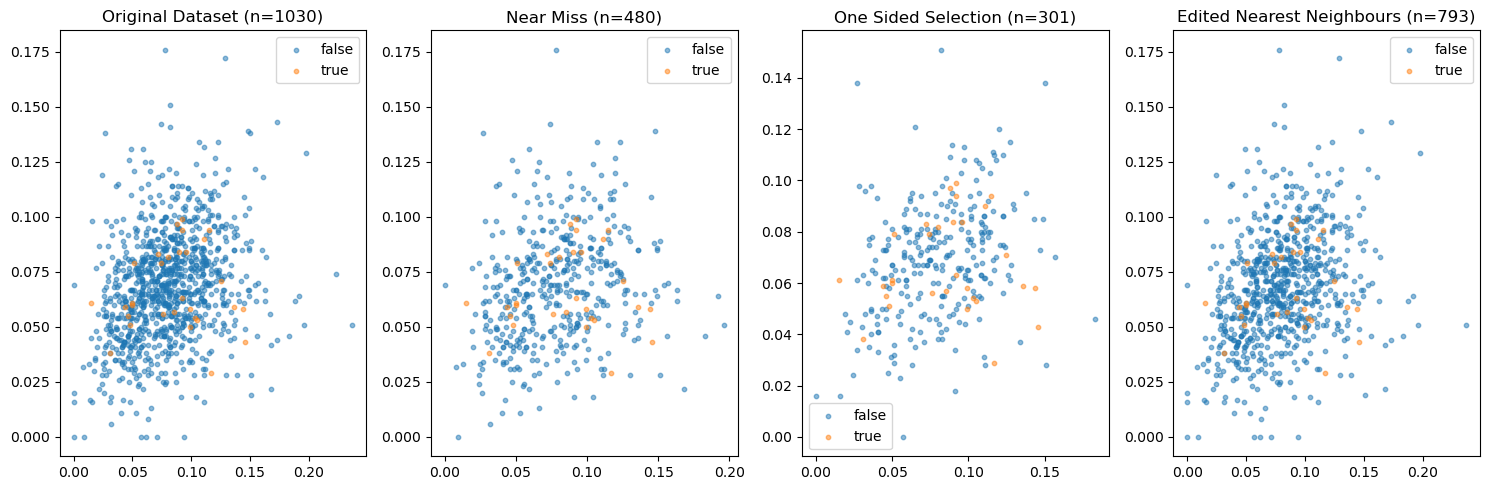

In [76]:
# np.random.seed(0)
from imblearn.under_sampling import *

f_id = np.where(y == False)[0]
np.random.shuffle(f_id)
f_id = f_id[:1000]
t_id = np.where(y == True)[0]
np.random.shuffle(t_id)
t_id = t_id[:30]

names = [["Original Dataset", "Near Miss"],
        ["One Sided Selection", "Edited Nearest Neighbours"]]
one = NearMiss(sampling_strategy=1/15, n_jobs=-1)
two = OneSidedSelection(sampling_strategy="majority", n_neighbors=3, n_seeds_S=50, n_jobs=-1)
three = EditedNearestNeighbours(sampling_strategy="majority", n_neighbors=11, n_jobs=-1)

X_rand = np.vstack((X[f_id], X[t_id]))
y_rand = np.hstack((y[f_id], y[t_id]))

X_y_p = [[(X_rand, y_rand), one.fit_resample(X_rand, y_rand)],
        [two.fit_resample(X_rand, y_rand), three.fit_resample(X_rand, y_rand)]]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

for i in range(2):
    for j in range(2):
        tmp1, tmp2 = X_y_p[i][j]
        
        for label in (0, 1):
            id_ = np.where(tmp2 == label)[0]
            ax[(i * 2) + j].scatter(tmp1[id_, 0], tmp1[id_, 1], s=10, alpha=0.5, label=str(label))
            ax[(i * 2) + j].legend(["false", "true"])
            ax[(i * 2) + j].set_title(names[i][j] + f" (n={len(tmp2)})")
            # ax[i, j].set_yticks([0, 0.05, 0.1, 0.15])
            # ax[i, j].set_xticks([0, 0.1, 0.2])
            
        
plt.tight_layout()
plt.savefig("../images/imb_scatters.png")
plt.show()    